In [1]:
from prometheus_api_client import PrometheusConnect, MetricRangeDataFrame
from prometheus_api_client.utils import parse_datetime
import pandas as pd
import pendulum
from tinydb import TinyDB, Query
from os import getenv
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your data is in the 'redpanda_kafka_data' DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import greenflow.analysis as an
import qgridnext as qgrid

In [2]:
import greenflow.analysis as an
from entrypoint import load_gin

cutoff = "2024-10-01T14:40:18.761822+02:00"

load_gin(exp_name="ingest-kafka", test=False)
experiments = an.get_experiments()

def interest(exp) -> bool:
  params = exp["experiment_metadata"]["factors"]["exp_params"]
  messageSize = params["messageSize"]
  partitions = params["partitions"]
  broker_cpu = int(params.get("broker_cpu", 0))
  if "Hammer" in exp["experiment_description"]:
    if "bw=25G" in exp["experiment_description"]:
      if broker_cpu == 16 and messageSize > 64 and partitions == 1:
        return True
  return False

redpanda_kafka_data = an.filter_experiments(experiments, interest, cutoff)


[WARNING]: failed to patch stdout/stderr for fork-safety: 'OutStream' object
has no attribute 'buffer'
[WARNING]: failed to reconfigure stdout/stderr with the replace error handler:
'OutStream' object has no attribute 'reconfigure'


In [3]:
# import dill
# dill.dump_session('montcalm_threshold.db')
# dill.load_session('montcalm_threshold.db')

In [4]:
# edit = True
edit = False

if edit:
  qgrid_widget = qgrid.show_grid(redpanda_kafka_data, show_toolbar=True)


In [5]:
# qgrid_widget

In [6]:
if edit:
  redpanda_kafka_data = qgrid_widget.get_changed_df()
enriched_data = an.enrich_dataframe(redpanda_kafka_data)
if edit:
  qgrid_widget = qgrid.show_grid(enriched_data, show_toolbar=True)
  qgrid_widget

In [7]:
if edit:
  enriched_data = qgrid_widget.get_changed_df()

# The throughput gap should be negative
enriched_data = enriched_data[enriched_data["throughput_gap_percentage"] <= 0]

In [8]:
qgrid_widget = qgrid.show_grid(enriched_data, show_toolbar=True)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

import yaml
import csv
import pyperclip
import io

csv_data = []

# Define the header
header = [
    # "experiment_id",
    "exp_name",
    "broker_cpu",
    "messageSize",
    "observed_throughput",
    # "dashboard_url",
    # "control_hosts",
    # "worker_hosts",
    # "job_id",
    # "job_site",
    # "job_started_ts",
    # "deployment_type",
    # "exp_params_duration",
    # "exp_params_instances",
    # "exp_params_kafkaOnWorker",
    # "exp_params_load",
    # "exp_params_warmup",
    # "started_ts",
    # "stopped_ts"
]
# csv_data.append(header)

for row in enriched_data.iterrows():
    data = row[1]
    row_data = [
        # data["experiment_id"],
        data["exp_name"],
        data["broker_cpu"],
        data["messageSize"],
        data["observed_throughput"],
        # data["dashboard_url"],
        # data["control_hosts"],
        # data["worker_hosts"],
        # data["job_id"],
        # data["job_site"],
        # data["job_started_ts"],
        # data["deployment_type"],
        # data["exp_params_duration"],
        # data["exp_params_instances"],
        # data["exp_params_kafkaOnWorker"],
        # data["exp_params_load"],
        # data["exp_params_warmup"],
        # data["started_ts"],
        # data["stopped_ts"]
    ]
    csv_data.append(row_data)
# csv_data = [header] + sorted(csv_data[1:], key=lambda x: int(x[0]))
# Convert csv_data to CSV format as a string using a StringIO buffer
output = io.StringIO()
writer = csv.writer(output)
writer.writerows(csv_data)

# Copy to clipboard
# pyperclip.copy(output.getvalue())
print(output.getvalue())
output.close()


# Set the threshold for significantly lower throughput
throughput_threshold = -20
latency_threshold = 1.5

data = enriched_data

ingest-redpanda,16,10240,59926.4
ingest-redpanda,16,9216,54249.26
ingest-redpanda,16,8192,62432.58
ingest-redpanda,16,7168,93720.38
ingest-redpanda,16,6144,149142.86
ingest-redpanda,16,5120,209416.02
ingest-redpanda,16,4096,164248.89
ingest-redpanda,16,3072,338270.27
ingest-redpanda,16,2048,366209.96
ingest-redpanda,16,1024,724812.45
ingest-redpanda,16,512,2125755.87
ingest-redpanda,16,128,7510906.8
ingest-kafka,16,10240,37684.93
ingest-kafka,16,9216,39689.17
ingest-kafka,16,8192,40061.75
ingest-kafka,16,7168,61219.9
ingest-kafka,16,6144,64014.9
ingest-kafka,16,5120,88431.99
ingest-kafka,16,4096,100594.67
ingest-kafka,16,3072,146235.45
ingest-kafka,16,2048,209157.2
ingest-kafka,16,1024,434548.2
ingest-kafka,16,512,852491.63
ingest-kafka,16,128,2934622.28



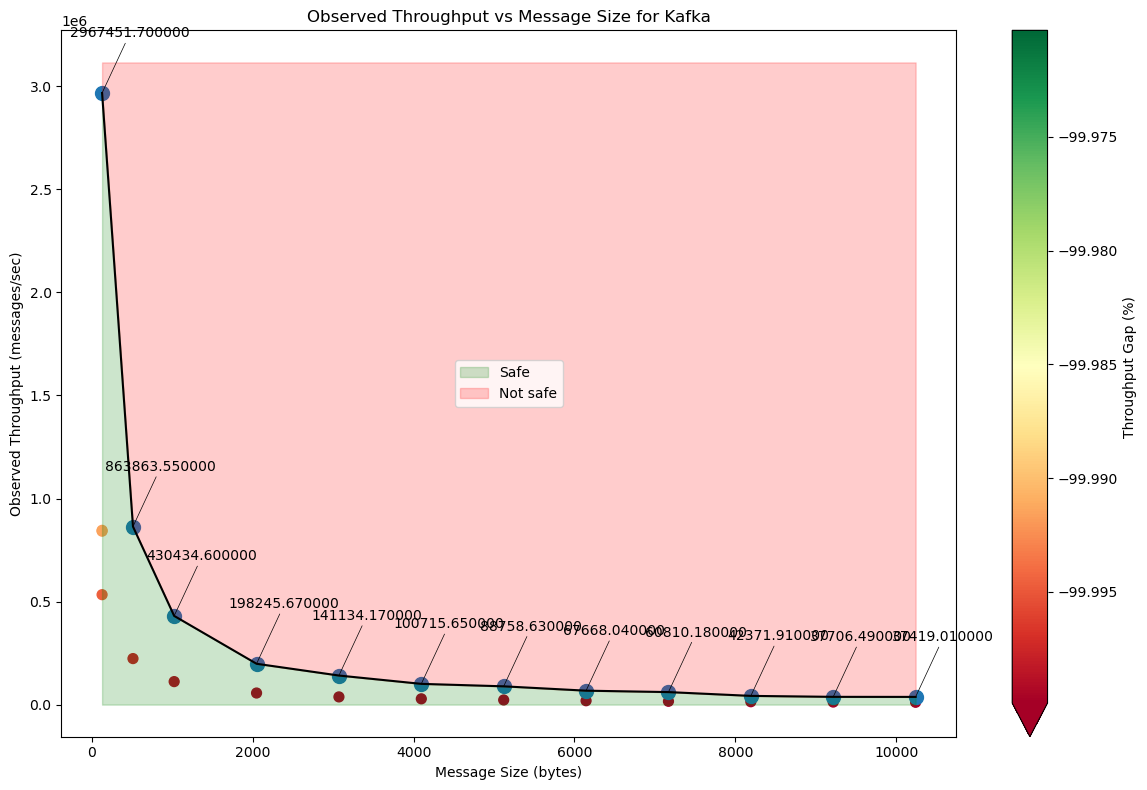

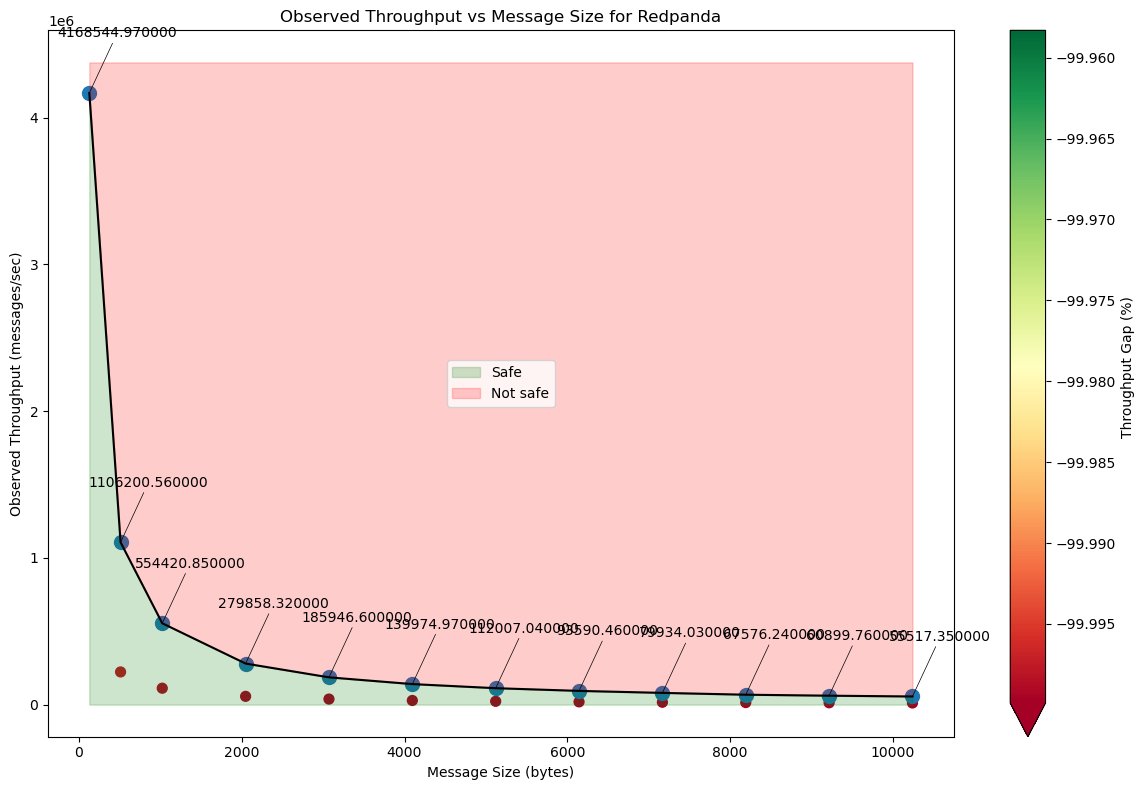

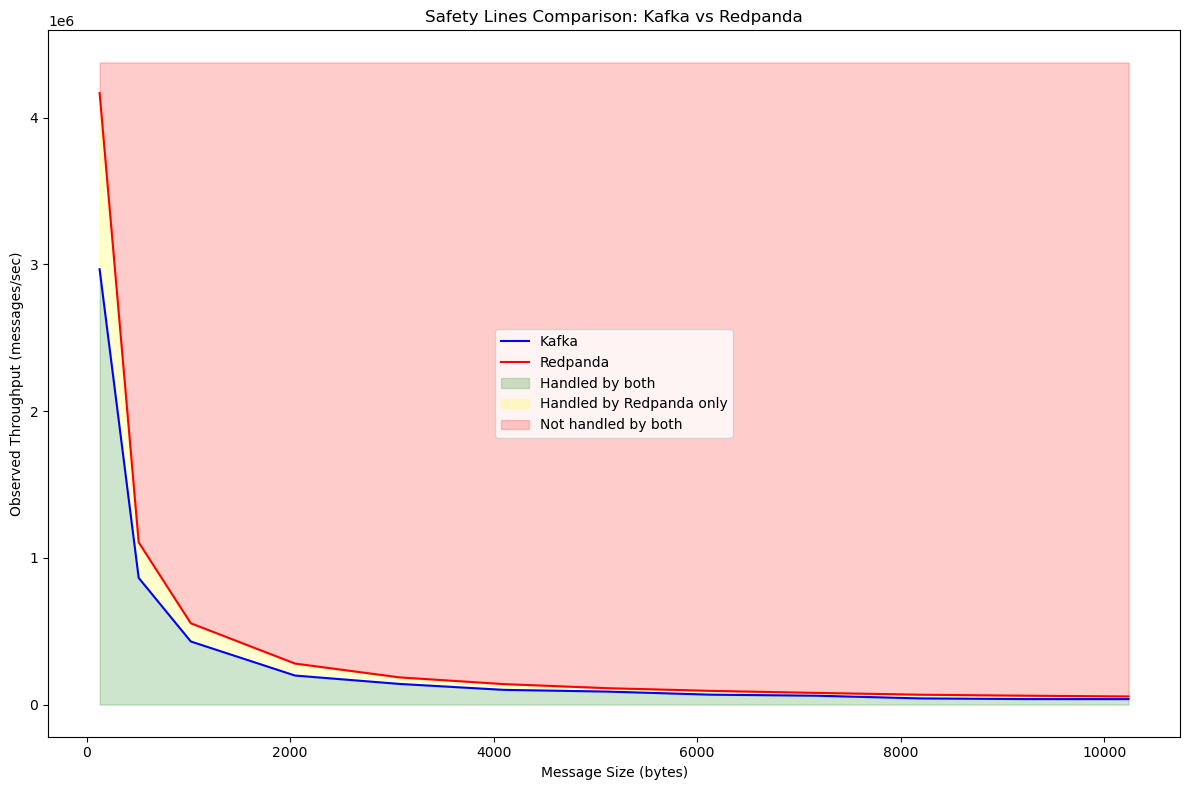

In [ ]:
import matplotlib.pyplot as plt

# Function to create the graph for a specific system
def create_graph(data, system_name):
    # Filter data for the specific system
    system_data = data

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    cmap = plt.cm.RdYlGn

    # Create scatter plot for all points except the last point for each message size
    scatter = ax.scatter(
        system_data["messageSize"][:-1],
        system_data["observed_throughput"][:-1],
        c=system_data["throughput_gap_percentage"][:-1],
        cmap=cmap,
        s=50,
    )

    # Create scatter plot for the last point of each message size with a different marker style
    last_points = system_data.groupby("messageSize").first()
    ax.scatter(
        last_points.index,
        last_points["observed_throughput"],
        s=100,
        marker="o",
        linewidths=1,
    )

    for idx, row in last_points.iterrows():
        ax.annotate(f"{row['observed_throughput']:f}", (idx, row['observed_throughput']), 
                    textcoords="offset points", xytext=(20, 40), ha='center',
                    arrowprops=dict(arrowstyle="-", color='black', linewidth=0.5, shrinkA=0, shrinkB=0))

    # Sort the last points by messageSize
    last_points = last_points.sort_index()

    # Connect the last points with a line
    ax.plot(last_points.index, last_points["observed_throughput"], linestyle="-", color="black")

    # Fill the area below the line as "Safe"
    ax.fill_between(last_points.index, last_points["observed_throughput"], color="green", alpha=0.2, label="Safe")

    # Fill the area above the line as "Not safe"
    ax.fill_between(last_points.index, last_points["observed_throughput"], y2=ax.get_ylim()[1], color="red", alpha=0.2, label="Not safe")

    # Add color bar
    plt.colorbar(scatter, ax=ax, label="Throughput Gap (%)", extend="min")

    ax.set_title(f"Observed Throughput vs Message Size for {system_name}")
    ax.set_xlabel("Message Size (bytes)")
    ax.set_ylabel("Observed Throughput (messages/sec)")

    # Add legend
    ax.legend()

    plt.tight_layout()
    plt.show()

    return last_points


# Create graphs for Montcalm and Neowise
kafka_last_points = create_graph(data[data["exp_name"] == "ingest-kafka"], "Kafka")
redpanda_last_points = create_graph(data[data["exp_name"] == "ingest-redpanda"], "Redpanda")

# Create a new figure for comparing the safety lines
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the safety lines for Kafka and Redpanda
ax.plot(kafka_last_points.index, kafka_last_points["observed_throughput"], linestyle="-", color="blue", label="Kafka")
ax.plot(redpanda_last_points.index, redpanda_last_points["observed_throughput"], linestyle="-", color="red", label="Redpanda")

# Fill the region that can be handled by both Kafka and Redpanda
ax.fill_between(kafka_last_points.index, kafka_last_points["observed_throughput"], color="green", alpha=0.2, label="Handled by both")

# Fill the region that can be handled by Redpanda but not Kafka
ax.fill_between(kafka_last_points.index, kafka_last_points["observed_throughput"], redpanda_last_points["observed_throughput"], where=(redpanda_last_points["observed_throughput"] > kafka_last_points["observed_throughput"]), color="yellow", alpha=0.2, label="Handled by Redpanda only")

# Fill the region that cannot be handled by both
ax.fill_between(redpanda_last_points.index, redpanda_last_points["observed_throughput"], y2=ax.get_ylim()[1], color="red", alpha=0.2, label="Not handled by both")

ax.set_title("Safety Lines Comparison: Kafka vs Redpanda")
ax.set_xlabel("Message Size (bytes)")
ax.set_ylabel("Observed Throughput (messages/sec)")

# Add legend
ax.legend()

plt.tight_layout()
plt.show()


KeyError: 'throughput_mBps'

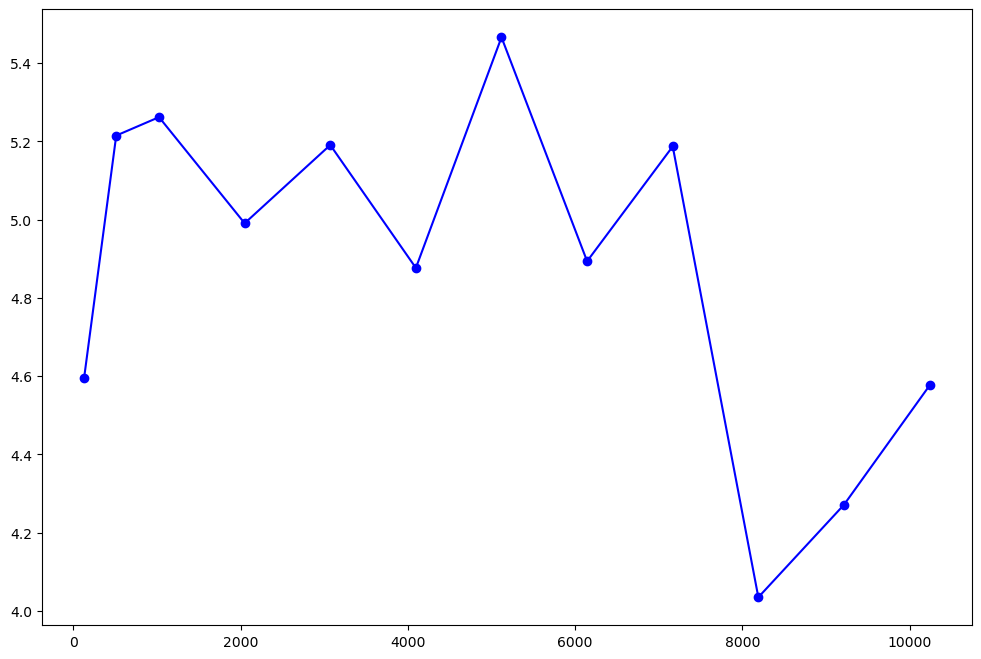

In [ ]:
# Create a new figure for comparing the throughput
fig, ax = plt.subplots(figsize=(12, 8))

# Plot Kafka throughput
ax.plot(kafka_last_points.index, kafka_last_points["throughput_per_watt"], 
        linestyle="-", marker="o", color="blue", label="Kafka")

# Plot Redpanda throughput
ax.plot(redpanda_last_points.index, redpanda_last_points["throughput_mBps"], 
        linestyle="-", marker="o", color="red", label="Redpanda")

ax.set_title("Throughput vs Message Size for Kafka and Redpanda")
ax.set_xlabel("Message Size (bytes)")
ax.set_ylabel("Throughput (MB/s)")
# ax.set_xscale('log')  # Set x-axis to logarithmic scale
# ax.set_yscale('log')  # Set y-axis to logarithmic scale

# Add legend
ax.legend()

# Add grid
ax.grid(True, which="both", ls="-", alpha=0.2)

# Annotate data points
for data, color in [(kafka_last_points, "blue"), (redpanda_last_points, "red")]:
    for idx, row in data.iterrows():
        ax.annotate(f"{row['throughput_per_watt']:.2f}", 
                    (idx, row['throughput_per_watt']), 
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center',
                    color=color,
                    fontsize=8)

plt.tight_layout()
plt.show()

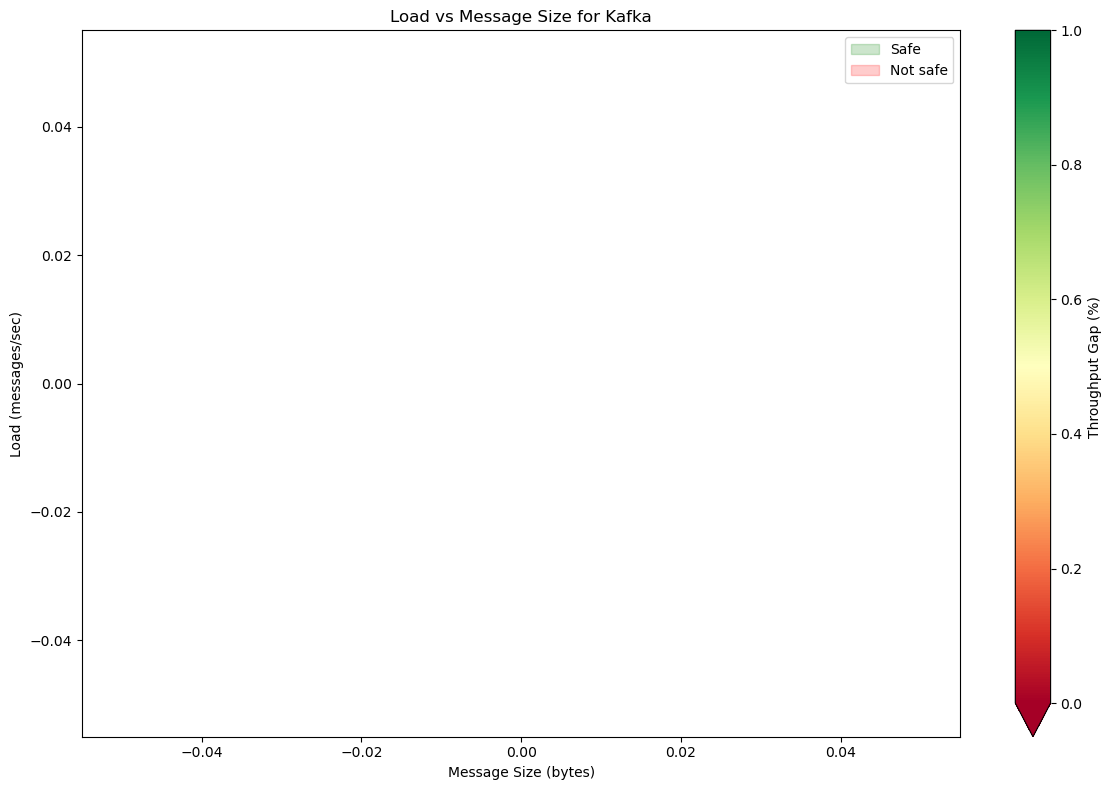

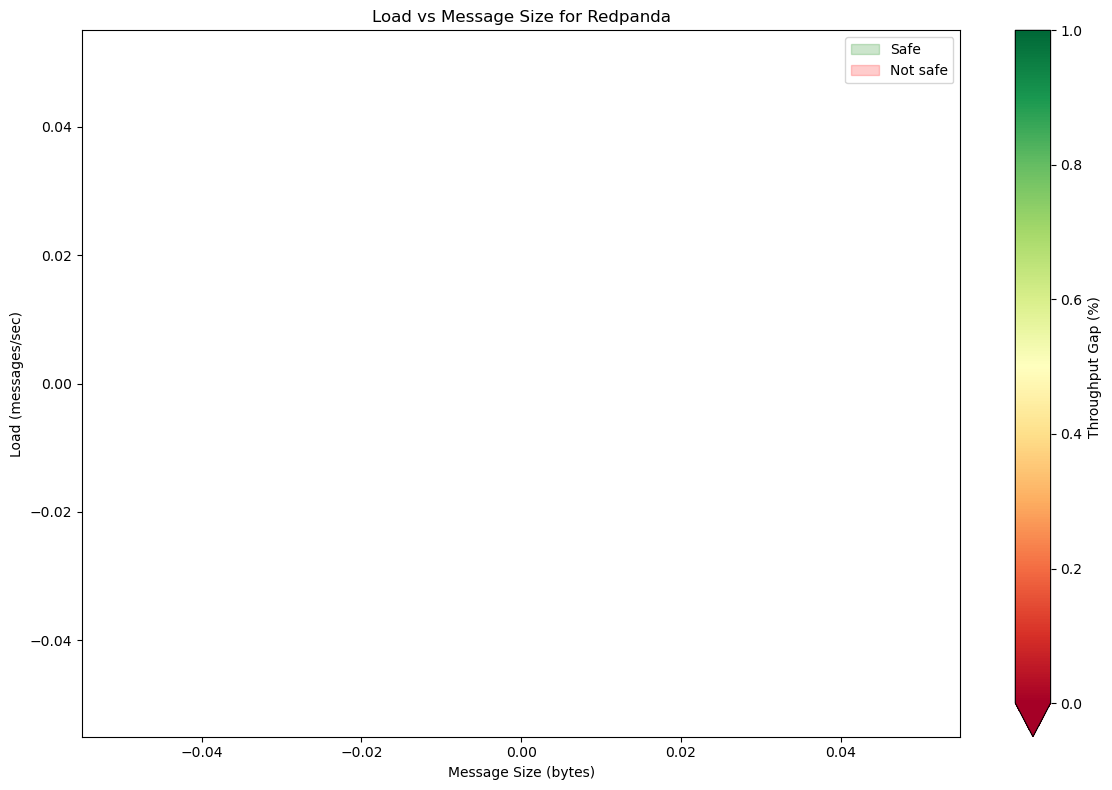

In [ ]:
data = enriched_data[enriched_data["throughput_gap_percentage"] >= -5]
def create_graph(data, system_name):
    # Filter data for the specific system
    system_data = data

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    cmap = plt.cm.RdYlGn

    # Create scatter plot for all points
    scatter = ax.scatter(
        system_data["messageSize"],
        system_data["load"],
        c=system_data["throughput_gap_percentage"],
        cmap=cmap,
        s=50,
    )

    # Find the maximum "safe" load for each message size
    # safe_data = system_data[system_data["throughput_gap_percentage"] >= -5]
    # max_safe_points = .groupby("messageSize").agg({"load": "max"}).reset_index()
    max_safe_points = system_data

    # Create scatter plot for the max safe points with a different marker style
    ax.scatter(
        max_safe_points["messageSize"],
        max_safe_points["load"],
        s=100,
        marker="o",
        linewidths=1,
        color="black",
    )

    for idx, row in max_safe_points.iterrows():
        ax.annotate(f"{row['load']:d}", (row['messageSize'], row['load']), 
                    textcoords="offset points", xytext=(20, 40), ha='center',
                    arrowprops=dict(arrowstyle="-", color='black', linewidth=0.5, shrinkA=0, shrinkB=0))

    # Sort the max safe points by messageSize
    max_safe_points = max_safe_points.sort_values("messageSize")

    # Connect the max safe points with a line
    ax.plot(max_safe_points["messageSize"], max_safe_points["load"], linestyle="-", color="black")

    # Fill the area below the line as "Safe"
    ax.fill_between(max_safe_points["messageSize"], max_safe_points["load"], color="green", alpha=0.2, label="Safe")

    # Fill the area above the line as "Not safe"
    ax.fill_between(max_safe_points["messageSize"], max_safe_points["load"], y2=ax.get_ylim()[1], color="red", alpha=0.2, label="Not safe")

    # Add color bar
    plt.colorbar(scatter, ax=ax, label="Throughput Gap (%)", extend="min")

    ax.set_title(f"Load vs Message Size for {system_name}")
    ax.set_xlabel("Message Size (bytes)")
    ax.set_ylabel("Load (messages/sec)")

    # Add legend
    ax.legend()

    plt.tight_layout()
    plt.show()

    return max_safe_points

# Create graphs for Kafka and Redpanda
kafka_max_safe_points = create_graph(data[data["exp_name"] == "ingest-kafka"], "Kafka")
redpanda_max_safe_points = create_graph(data[data["exp_name"] == "ingest-redpanda"], "Redpanda")


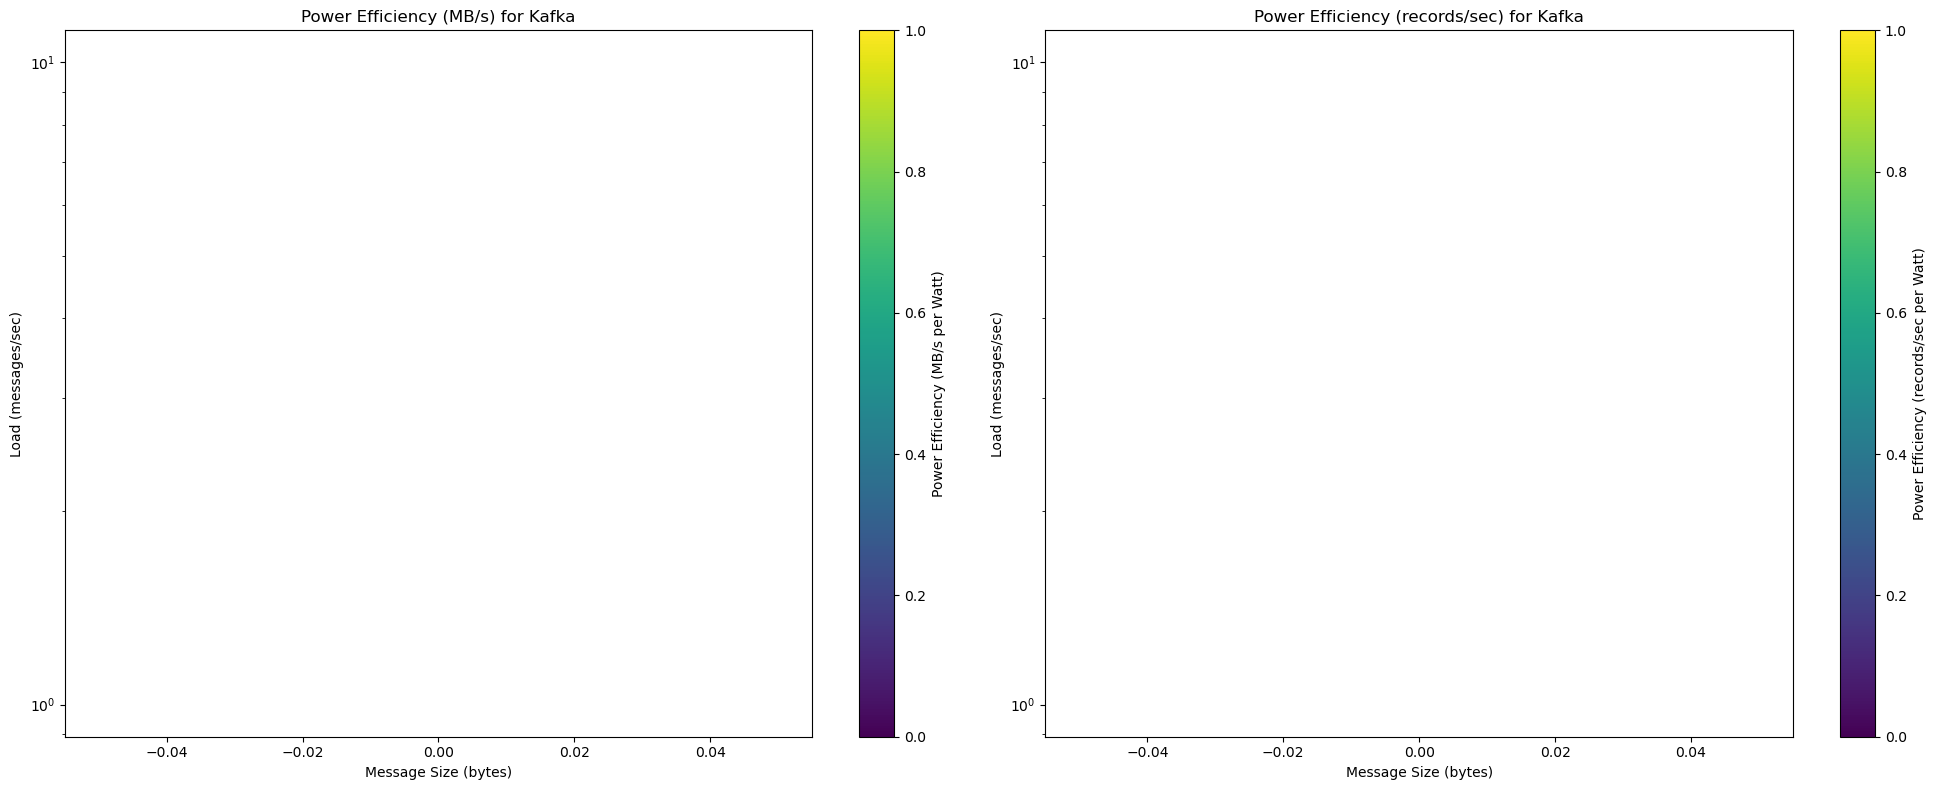

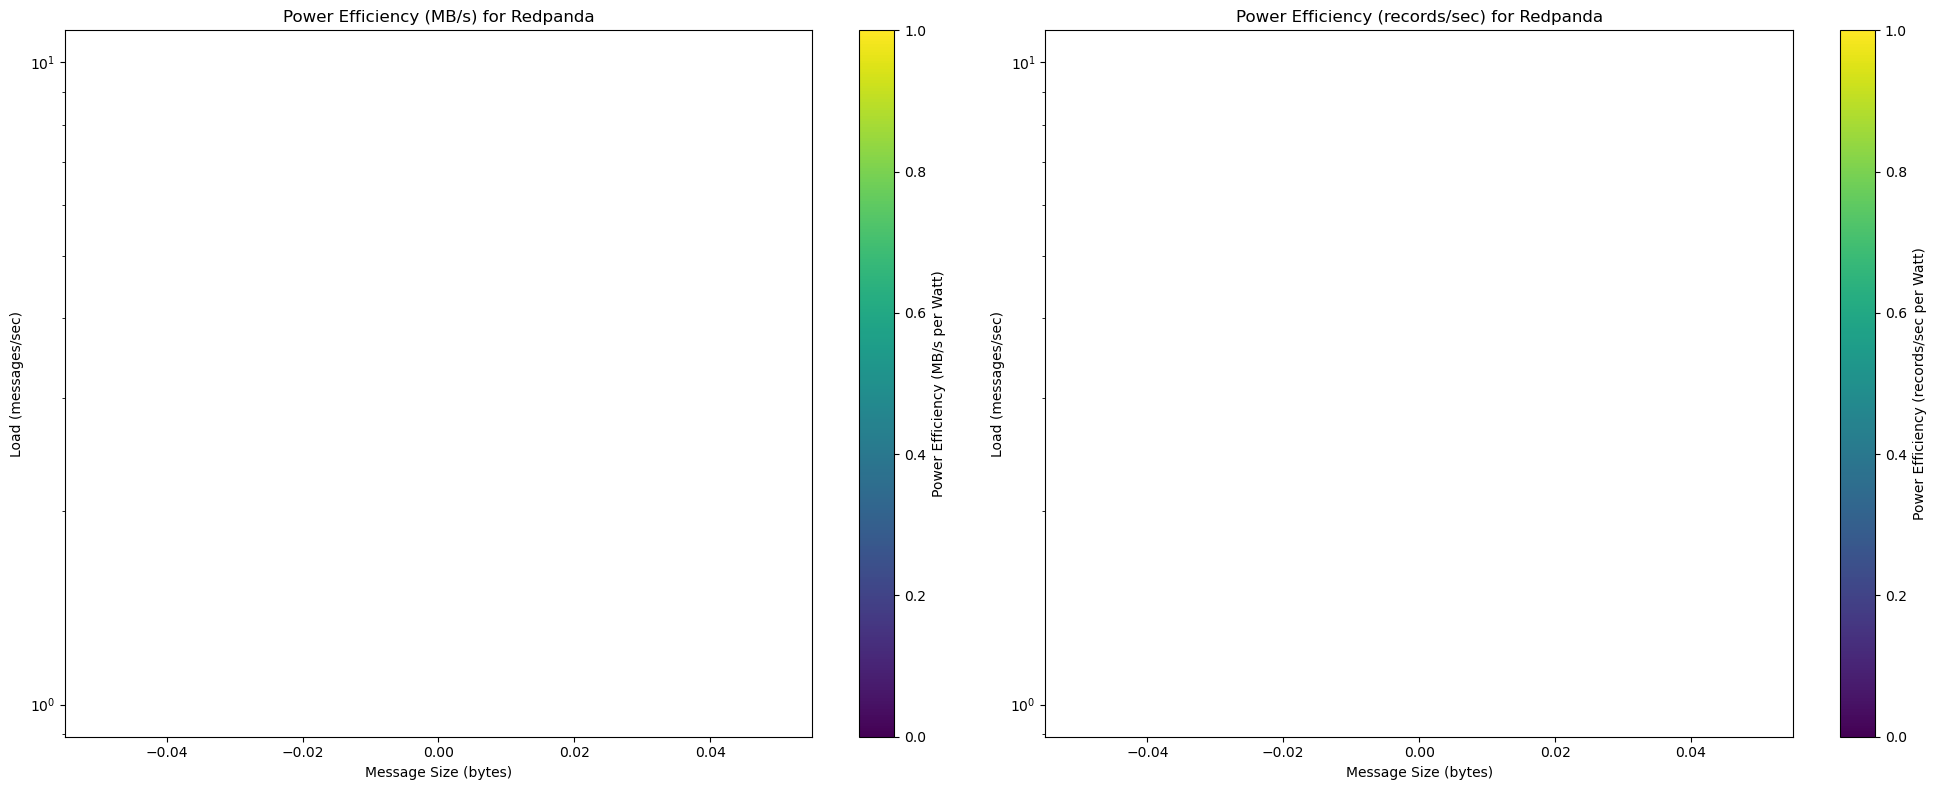

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

data = enriched_data
def plot_power_efficiency(data, system_name):
    # Filter data for the specific system and safe points
    safe_data = data[(data["exp_name"] == f"ingest-{system_name.lower()}") & (data["throughput_gap_percentage"] >= -5)].copy()

    # Calculate power efficiency
    safe_data.loc[:, 'power_efficiency_MBps'] = safe_data['throughput_MBps'] / safe_data['average_power']
    safe_data.loc[:, 'power_efficiency_records'] = safe_data['observed_throughput'] / safe_data['average_power']

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot for throughput in MB/s
    scatter1 = ax1.scatter(
        safe_data["messageSize"],
        safe_data["load"],
        c=safe_data["power_efficiency_MBps"],
        cmap="viridis",
        s=50,
    )

    ax1.set_title(f"Power Efficiency (MB/s) for {system_name}")
    ax1.set_xlabel("Message Size (bytes)")
    ax1.set_ylabel("Load (messages/sec)")
    # ax1.set_xscale('log')
    ax1.set_yscale('log')

    # Add color bar
    cbar1 = plt.colorbar(scatter1, ax=ax1)
    cbar1.set_label("Power Efficiency (MB/s per Watt)")

    # Plot for observed throughput in records/sec
    scatter2 = ax2.scatter(
        safe_data["messageSize"],
        safe_data["load"],
        c=safe_data["power_efficiency_records"],
        cmap="viridis",
        s=50,
    )

    ax2.set_title(f"Power Efficiency (records/sec) for {system_name}")
    ax2.set_xlabel("Message Size (bytes)")
    ax2.set_ylabel("Load (messages/sec)")
    # ax2.set_xscale('log')
    ax2.set_yscale('log')

    # Add color bar
    cbar2 = plt.colorbar(scatter2, ax=ax2)
    cbar2.set_label("Power Efficiency (records/sec per Watt)")

    plt.tight_layout()
    plt.show()

# Create power efficiency plots for Kafka and Redpanda
plot_power_efficiency(data, "Kafka")
plot_power_efficiency(data, "Redpanda")

# The rest of your code for creating the safety line comparison graph remains the same
